# Определение возраста покупателей

Сетевой супермаркет внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:

- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- Контролировать добросовестность кассиров при продаже алкоголя.

**Цель проекта:**  
построить модель, которая по фотографии определит приблизительный возраст человека.  
В нашем распоряжении имеется набор фотографий людей с указанием возраста.

# Исследовательский анализ данных

**Импорт библиотек**

In [1]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

**Импорт выборки**

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')
datagen = ImageDataGenerator(rescale=1./255)
gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


**Размер выборки**

In [3]:
labels.shape

(7591, 2)

**График распределения возраста в выборке.**

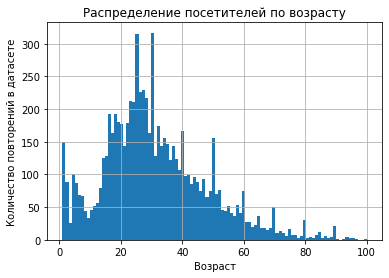

In [4]:
labels.hist(bins=100);
plt.title('Распределение посетителей по возрасту')
plt.ylabel('Количество повторений в датасете')
plt.xlabel('Возраст');

In [5]:
display(labels.describe())

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


**Вывод примеров фотографий из датасета.**

/tmp/ipykernel_862/1996195429.py:9: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


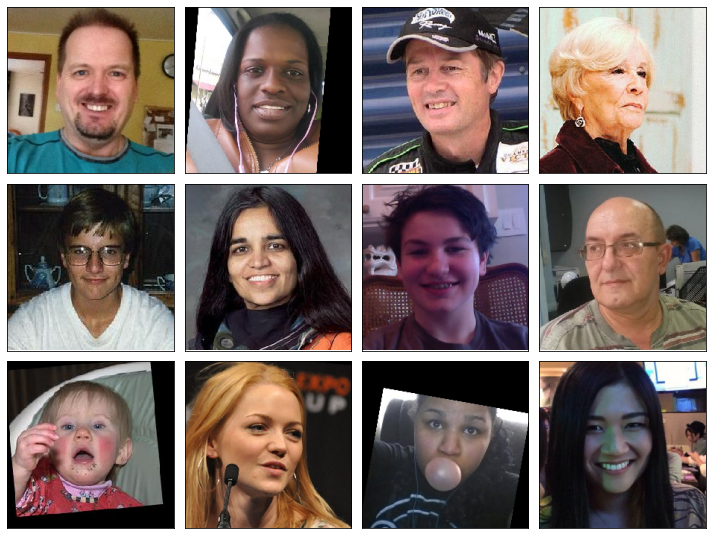

In [6]:
features, target = next(train_gen_flow)

fig = plt.figure(figsize=(10,10))
for i in range(12):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

**Вывод.**

В датасете содержится 7591 фотографий. Такого количества может оказаться недостаточно для оценки возраста.

Основная масса фотографий по возрасту находится в диапазоне от 20 до 41 года. 

На фотографиях присутствуют объекты, которые закрывают лицо: рука, жвачка, очки, головной убор и т.д., что может осложнить обучение модели и дальнейшее определение возраста.

# Обучение модели

**Импорт данных**

In [8]:
def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(validation_split=0.25, horizontal_flip=True, rescale=1./255)
    train_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345)

    return train_gen_flow

In [9]:
def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)
    test_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345)

    return test_gen_flow

**Определение модели**

In [10]:
def create_model(input_shape):

    backbone = ResNet50(input_shape=input_shape,
                    weights='imagenet', 
                    include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))

    optimizer = Adam(lr=0.0001)
    model.compile(optimizer=optimizer, loss='mean_squared_error',
                  metrics=['mae'])


    return model

**Обучение модели**

In [11]:
def train_model(model, train_data, test_data, batch_size=None, epochs=10,
                steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, 
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model

**Вывод результата работы модели**

Train for 356 steps, validate for 119 steps
Epoch 1/10
2023-08-07 21:03:23.524763: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-08-07 21:03:23.805428: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
356/356 - 52s - loss: 204.7335 - mae: 10.3599 - val_loss: 625.5962 - val_mae: 19.9337
Epoch 2/10
356/356 - 43s - loss: 86.0203 - mae: 7.0012 - val_loss: 166.2130 - val_mae: 9.7210
Epoch 3/10
356/356 - 43s - loss: 57.4289 - mae: 5.7877 - val_loss: 84.4957 - val_mae: 7.0086
Epoch 4/10
356/356 - 43s - loss: 43.2552 - mae: 5.0222 - val_loss: 82.1608 - val_mae: 6.8003
Epoch 5/10
356/356 - 45s - loss: 32.3904 - mae: 4.3556 - val_loss: 79.1960 - val_mae: 6.6406
Epoch 6/10
356/356 - 46s - loss: 25.4213 - mae: 3.8632 - val_loss: 70.0693 - val_mae: 6.2512
Epoch 7/10
356/356 - 45s - loss: 20.8413 - mae: 3.4868 - val_loss: 71.7964 - val_mae: 6.3204
Epoch 8/10
356/356 - 46s - loss: 16.1793 - mae: 3.0915 - val_loss: 70.5651 - val_mae: 6.4249
Epoch 9/10
356/356 - 46s - loss: 14.8690 - mae: 2.9299 - val_loss: 73.7600 - val_mae: 6.5666
Epoch 10/10
356/356 - 46s - loss: 13.6367 - mae: 2.7902 - val_loss: 72.1433 - val_mae: 6.3334
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
119/119 - 11s - loss: 72.1433 - mae: 6.3334
Test MAE: 6.3334

**Вывод:**

Для построения модели сверточной нейронной сети была применена технология ResNet50.

В процессе обучения за 10 эпох обучения удалось уменьшить MAE с 10 до 2.8 на тренировочной выборке и достичь уровня MAE=6.33 на тестовой выборке. Это ниже установленного условиями проекта порогового уровня MAE=7, следовательно требования заказчика выполнены.

# Анализ результата обучения модели

Обученная модель позволяет с хорошей точностью предсказывать возраст покупателей.  

Полученное значение МАЕ = 6.33 на тестовой выборке  - достаточный показатель, поскольку для отнесения покупателей в ту или иную возрастную категорию погрешность в 6 лет вполне приемлема.

**Рекомендация для сотрудников супермаркета:**  
Использование разработанной в рамках данного проекта модели на базе нейронных сетей позволяет эффективно по фотографии определять приблизительный возраст человека с целью анализа покупок по разным возрастным группам и контролировать добросовестность кассиров при продаже алкоголя.